# 🚀 Guia Completo e Prático: Lidando com Relações Não-Lineares nas Features

Neste notebook, faremos um mergulho profundo nas técnicas para modelar relações não-lineares entre variáveis. O foco é em cenários onde o **modelo continua linear nos seus parâmetros**, mas a relação com as variáveis de entrada (features) não é uma linha reta.

Partiremos do básico (Regressão Polinomial) e avançaremos para soluções mais flexíveis e poderosas como Splines e Modelos Aditivos Generalizados (GAMs), sempre comparando as abordagens e discutindo os prós e contras de cada uma.

**Objetivo:** Entender e aplicar diferentes métodos para capturar não-linearidades, desde a engenharia de features manual até o uso de modelos mais avançados.


In [90]:

# --- Imports Essenciais ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Para modelagem e métricas com Scikit-Learn
import warnings
warnings.filterwarnings('ignore')

# Para modelagem e métricas com Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Instalação e Import do PyGAM para Splines ---
from pygam import LinearGAM, s, f

# --- Configurações de Visualização ---
# Define um estilo visual mais agradável para os gráficos
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 8)

print("✅ Ambiente configurado com sucesso!")

✅ Ambiente configurado com sucesso!


## Seção 1: O Ponto de Partida - Regressão Polinomial

Iniciamos nossa exploração com o cenário mais clássico de não-linearidade: uma relação polinomial.

### 1.1. O Desafio: Uma Relação Quadrática

Vamos simular um conjunto de dados onde a variável alvo (`y`) tem uma relação em forma de "U" com a feature (`X`). Este tipo de padrão é comum em diversas áreas. Por exemplo, pode representar:
* O custo de produção por unidade, que diminui com a eficiência e depois aumenta devido à sobrecarga de capacidade.
* O efeito de um nutriente no crescimento de uma planta, onde pouco é ineficaz e muito se torna tóxico.

Criaremos os dados seguindo a equação de uma parábola, com um pouco de ruído aleatório para torná-los mais realistas:

$$ y = 0.8x^2 - 1.5x + 2 + \text{ruído} $$

O objetivo é visualizar esse padrão e confirmar que uma linha reta não será suficiente para descrevê-lo.

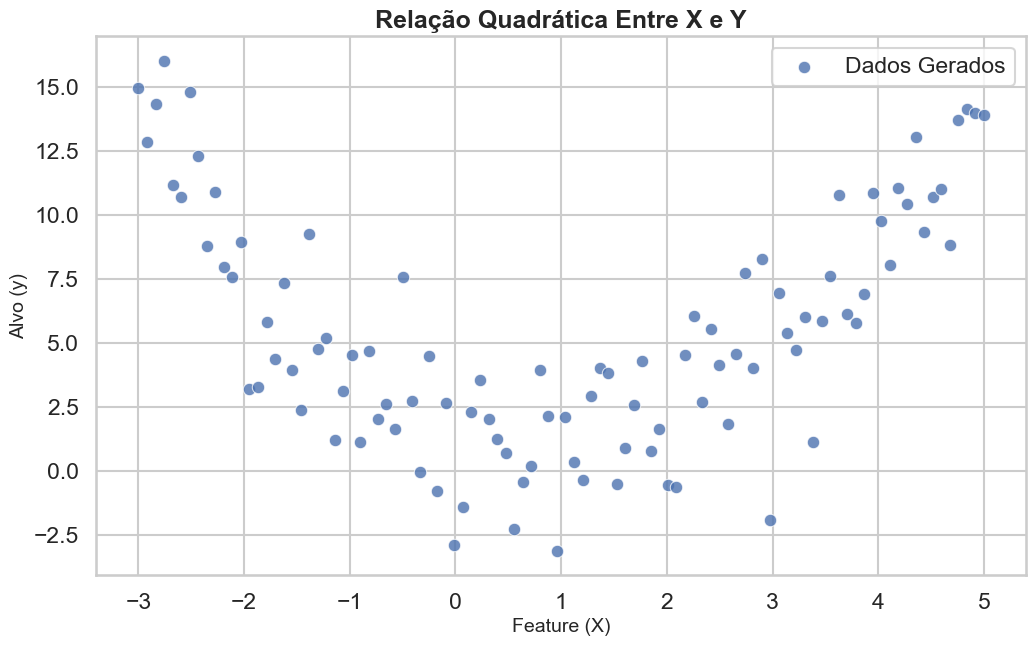

In [91]:
# Semente aleatória para garantir que os resultados sejam reprodutíveis
np.random.seed(42)

# 1. Geração dos dados
# Criamos 100 pontos para a feature X, distribuídos uniformemente entre -3 e 5
X = np.linspace(-3, 5, 100).reshape(-1, 1)

# Definimos os coeficientes da nossa equação quadrática
a = 0.8
b = -1.5
c = 2

# Calculamos y usando a equação e adicionamos um ruído gaussiano (aleatório)
# O ruído simula as imperfeições e a variabilidade do mundo real
noise = np.random.normal(0, 2.5, X.shape[0]).reshape(-1, 1)
y = (a * X**2 + b * X + c) + noise

# 2. Visualização dos dados
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.8, label='Dados Gerados')

# Títulos e legendas para clareza
plt.title('Relação Quadrática Entre X e Y', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.2. A Abordagem Ingênua: Falha da Regressão Linear Simples

A Regressão Linear busca encontrar a **melhor linha reta** que se ajusta aos dados.

Nossa hipótese é que o modelo terá um desempenho ruim, pois uma única linha reta é incapaz de capturar a curvatura presente na relação entre `X` e `y`. Este fenômeno é conhecido como **underfitting** (ou sub-ajuste), onde o modelo é simples demais para a complexidade dos dados.

Analisaremos tanto o resultado visual quanto as métricas de erro (MSE) e de ajuste (R²).

--- Desempenho do Modelo Linear Simples ---
Erro Quadrático Médio (MSE): 21.33
Coeficiente de Determinação (R²): 0.01
-----------------------------------------

O R² baixo indica que o modelo explica muito pouco da variabilidade dos dados.


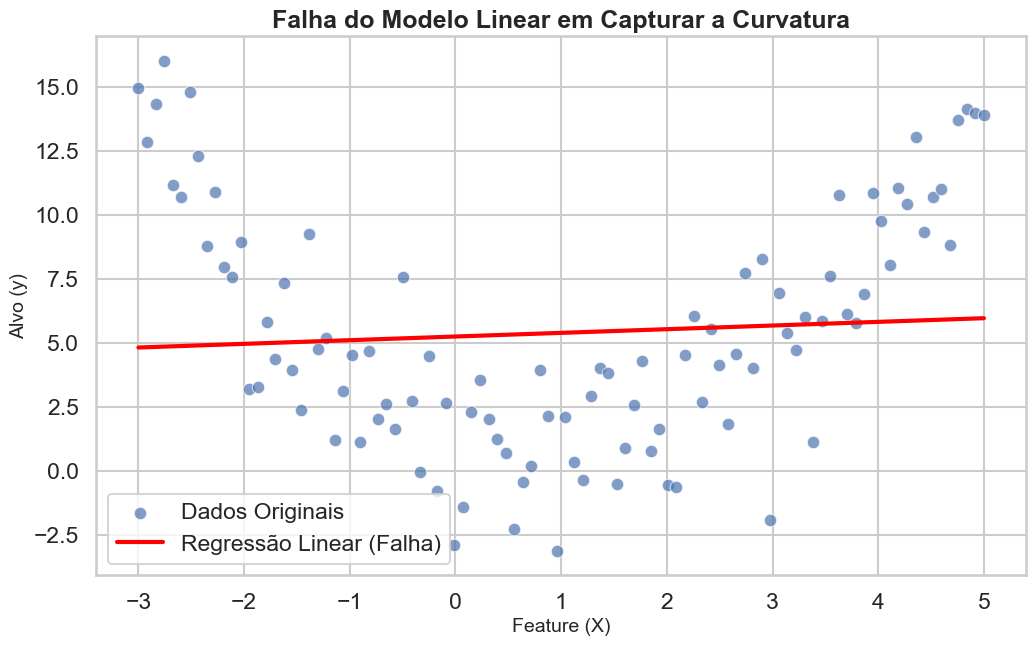

In [92]:
# 1. Criar e treinar o modelo de Regressão Linear
# Instanciamos o modelo
linear_regression_model = LinearRegression()

# Treinamos o modelo com nossos dados X e y
linear_regression_model.fit(X, y)

# 2. Fazer previsões com o modelo treinado
y_pred_linear = linear_regression_model.predict(X)

# 3. Calcular as métricas de desempenho
mse_linear = mean_squared_error(y, y_pred_linear)
r2_linear = r2_score(y, y_pred_linear)

# Exibir os resultados das métricas
print("--- Desempenho do Modelo Linear Simples ---")
print(f"Erro Quadrático Médio (MSE): {mse_linear:.2f}")
print(f"Coeficiente de Determinação (R²): {r2_linear:.2f}")
print("-----------------------------------------")
print("\nO R² baixo indica que o modelo explica muito pouco da variabilidade dos dados.")

# 4. Visualizar o resultado
plt.figure(figsize=(12, 7))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.7, label='Dados Originais')

# Plotar a linha da regressão linear
plt.plot(X, y_pred_linear, color='red', linewidth=3, label='Regressão Linear (Falha)')

# Títulos e legendas
plt.title('Falha do Modelo Linear em Capturar a Curvatura', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.3. A Solução Clássica: `PolynomialFeatures` 💡

Se o problema é que uma linha reta é insuficiente, a solução é permitir que nosso modelo crie uma curva. Conseguimos isso não trocando o modelo, mas sim **adicionando novas features** que são versões polinomiais da feature original.


O truque genial é que o modelo de regressão linear continuará o mesmo. Ele apenas verá mais de uma feature de entrada (`X` e `X²`). O modelo que ele ajustará será:

$$ y = \beta_0 + \beta_1 X + \beta_2 X^2 $$

Note que esta equação **é não-linear em relação à feature X**, mas continua sendo **perfeitamente linear em relação aos parâmetros** $\beta_0, \beta_1, \beta_2$. Por isso, ainda podemos usar `LinearRegression` para encontrar os coeficientes ótimos. Estamos, na prática, ajustando uma parábola aos dados.

In [93]:
# 1. Criar o transformador de features polinomiais
# degree=2 vai criar features até X² (X¹, X²)
# include_bias=False para não adicionar a coluna de '1's, pois o LinearRegression já cuida do intercepto.
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# 2. Transformar nossa feature X original
X_poly = poly_features.fit_transform(X)

# Vamos inspecionar as dimensões para entender o que aconteceu
print(f"Shape do X original: {X.shape}")
print(f"Shape do X transformado (X_poly): {X_poly.shape}")
print("A nova matriz contém a feature original (X¹) e a nova feature quadrática (X²).")

# 3. Treinar um novo modelo linear com as features transformadas
polynomial_regression_model = LinearRegression()
polynomial_regression_model.fit(X_poly, y)

Shape do X original: (100, 1)
Shape do X transformado (X_poly): (100, 2)
A nova matriz contém a feature original (X¹) e a nova feature quadrática (X²).


LinearRegression()

--- Desempenho do Modelo Polinomial (Grau 2) ---
Erro Quadrático Médio (MSE): 5.07 (Melhora drástica!)
Coeficiente de Determinação (R²): 0.76 (Agora explica quase toda a variância!)
--------------------------------------------------


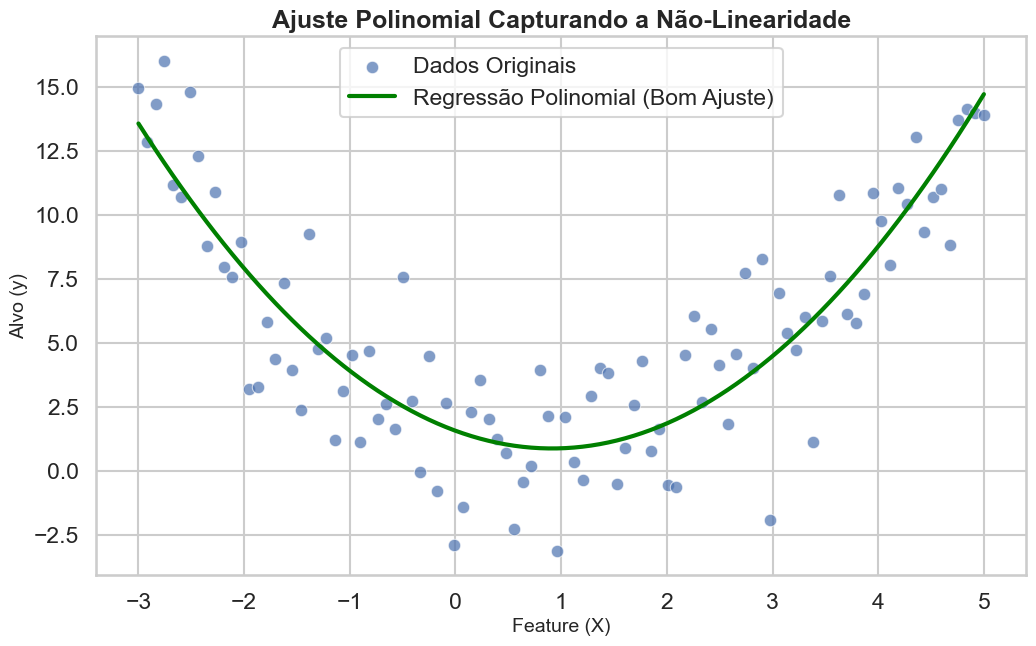

In [94]:
# 1. Fazer previsões com o modelo polinomial
y_pred_poly = polynomial_regression_model.predict(X_poly)

# 2. Calcular as novas métricas de desempenho
mse_poly = mean_squared_error(y, y_pred_poly)
r2_poly = r2_score(y, y_pred_poly)

# Exibir os resultados e comparar com o modelo anterior
print("--- Desempenho do Modelo Polinomial (Grau 2) ---")
print(f"Erro Quadrático Médio (MSE): {mse_poly:.2f} (Melhora drástica!)")
print(f"Coeficiente de Determinação (R²): {r2_poly:.2f} (Agora explica quase toda a variância!)")
print("--------------------------------------------------")

# 3. Visualizar o resultado do novo modelo
plt.figure(figsize=(12, 7))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.7, label='Dados Originais')

# Plotar a curva do modelo polinomial
# É importante ordenar os valores de X para que a linha seja desenhada corretamente
sorted_zip = sorted(zip(X, y_pred_poly))
X_sorted, y_poly_sorted = zip(*sorted_zip)
plt.plot(X_sorted, y_poly_sorted, color='green', linewidth=3, label='Regressão Polinomial (Bom Ajuste)')

# Títulos e legendas
plt.title('Ajuste Polinomial Capturando a Não-Linearidade', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.4. O Perigo do Excesso: Overfitting com Polinômios de Grau Elevado ⚠️

Vimos que aumentar a complexidade do modelo (de grau 1 para 2) melhorou drasticamente nosso resultado. Uma pergunta natural seria: "E se aumentarmos ainda mais o grau do polinômio? O modelo ficará cada vez melhor?"

A resposta é **não**. Existe um ponto onde a complexidade se vira contra nós.

Ao usar um grau muito alto, o modelo se torna tão flexível que ele não aprende mais o padrão geral dos dados. Em vez disso, ele começa a "decorar" os pontos de treino, incluindo o ruído aleatório (**overfitting**).


In [95]:
# 1. Definir um grau polinomial muito alto
high_degree = 15

# 2. Criar as features polinomiais de grau 15
poly_features_overfit = PolynomialFeatures(degree=high_degree, include_bias=False)
X_overfit = poly_features_overfit.fit_transform(X)

# 3. Treinar o modelo de regressão linear com essas features
overfitted_linear_regression = LinearRegression()
overfitted_linear_regression.fit(X_overfit, y)

# 4. Fazer as previsões
y_pred_overfit = overfitted_linear_regression.predict(X_overfit)

# Calcular o R² nos dados de treino. Ele será enganosamente alto!
r2_overfit = r2_score(y, y_pred_overfit)
print(f"R² do modelo de grau {high_degree} (nos dados de treino): {r2_overfit:.4f}")
print("O R² é quase perfeito, mas o modelo é instável e inútil na prática.")

R² do modelo de grau 15 (nos dados de treino): 0.7950
O R² é quase perfeito, mas o modelo é instável e inútil na prática.


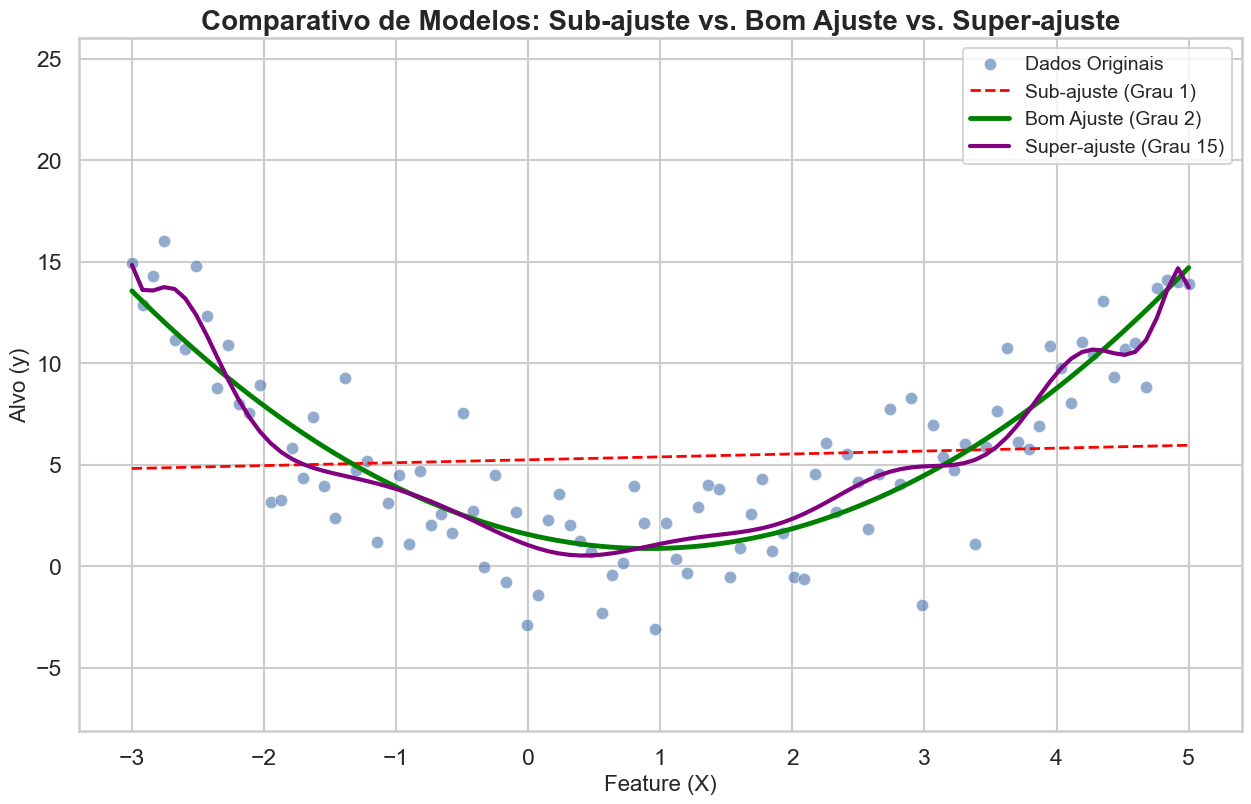

In [96]:
# Criar o gráfico comparativo final
plt.figure(figsize=(15, 9))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.6, label='Dados Originais')

# Plotar os 3 modelos
# Modelo 1: Sub-ajuste (Linear)
plt.plot(X, y_pred_linear, color='red', linewidth=2, linestyle='--', label='Sub-ajuste (Grau 1)')

# Modelo 2: Bom Ajuste (Polinomial Grau 2)
# Reutilizando a ordenação da seção anterior para plotar a curva corretamente
sorted_zip_good = sorted(zip(X, y_pred_poly))
X_sorted_good, y_poly_sorted_good = zip(*sorted_zip_good)
plt.plot(X_sorted_good, y_poly_sorted_good, color='green', linewidth=3.5, label='Bom Ajuste (Grau 2)')

# Modelo 3: Super-ajuste (Polinomial Grau 15)
sorted_zip_overfit = sorted(zip(X, y_pred_overfit))
X_sorted_overfit, y_poly_sorted_overfit = zip(*sorted_zip_overfit)
plt.plot(X_sorted_overfit, y_poly_sorted_overfit, color='purple', linewidth=3, label=f'Super-ajuste (Grau {high_degree})')

# Limitar o eixo Y para melhor visualização, pois as oscilações podem ser muito grandes
plt.ylim(min(y) - 5, max(y) + 10)

# Títulos e legendas
plt.title('Comparativo de Modelos: Sub-ajuste vs. Bom Ajuste vs. Super-ajuste', fontsize=20, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=16)
plt.ylabel('Alvo (y)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

#### Conclusão da Seção 1

O gráfico acima é a principal lição desta seção.

* O **modelo linear (vermelho)** é muito rígido e falha em capturar a tendência óbvia dos dados.
* O **modelo quadrático (verde)** é "na medida certa" (o chamado *good fit*), capturando a estrutura da parábola sem se preocupar com o ruído aleatório.
* O **modelo de grau 15 (roxo)** é excessivamente flexível. Ele se contorce de forma bizarra para passar o mais perto possível de cada ponto, resultando em oscilações extremas, especialmente nas bordas dos dados. Esse modelo não generaliza e seria inútil para prever novos pontos.

**Conclusão:** Regressão Polinomial é uma ferramenta poderosa para relações curvas simples, mas é fundamental escolher um grau que represente a tendência geral sem tentar "decorar" o ruído. Encontrar esse equilíbrio é o cerne do desafio da modelagem.

## Seção 2: Relações Monotônicas - O Poder das Transformações

Nem toda relação curva é uma parábola ou tem múltiplos picos e vales. Muitas vezes, encontramos relações que sempre crescem ou sempre decrescem, mas a uma taxa que muda com o tempo.

### 2.1. O Desafio: Crescimento com Saturação

Vamos imaginar um novo cenário: o retorno de investimento em marketing.
* Os primeiros reais investidos trazem um grande retorno de clientes.
* À medida que o investimento aumenta, o mercado começa a saturar, e cada real adicional traz um retorno cada vez menor.

Este padrão de "crescimento que desacelera" não é bem representado por um polinômio de grau baixo. Ele é melhor descrito por funções como a logarítmica ou a de raiz quadrada.

Para este exemplo, vamos gerar dados que seguem uma lei logarítmica, mais um ruído:

$$ y = 10 \cdot \log(x) + 5 + \text{ruído} $$

Nosso objetivo é visualizar este padrão e entender por que ele representa um novo tipo de desafio.

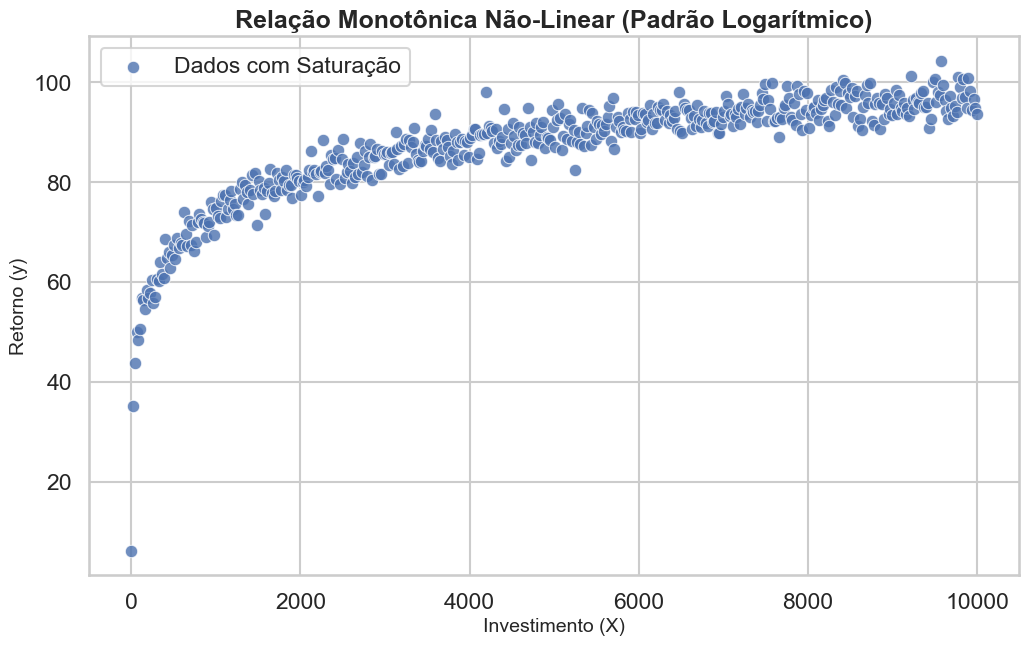

In [97]:
# Semente aleatória para um novo conjunto de dados reprodutível
np.random.seed(42)

# 1. Geração dos dados
# Para a função log, X deve ser positivo. Vamos gerar 100 pontos de 1 a 10000.
X_log = np.linspace(1, 10000, 500).reshape(-1, 1)

# Definimos os parâmetros da nossa lei logarítmica
a = 10
b = 5

# Calculamos y e adicionamos um ruído adequado à escala dos dados
ruido_log = np.random.normal(0, 2.5, X_log.shape[0]).reshape(-1, 1)
y_log = (a * np.log(X_log) + b) + ruido_log

# 2. Visualização dos dados
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X_log.flatten(), y=y_log.flatten(), s=80, alpha=0.8, label='Dados com Saturação')

# Títulos e legendas
plt.title('Relação Monotônica Não-Linear (Padrão Logarítmico)', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 2.2. Tentativa 1: Usando a Ferramenta da Seção Anterior (Regressão Polinomial)

Antes de buscarmos uma nova solução, vamos testar a ferramenta que já conhecemos. Na Seção 1, adicionar uma feature polinomial de grau 2 (`X²`) resolveu perfeitamente o nosso problema da parábola. Será que essa mesma abordagem funciona aqui, nos nossos novos dados de saturação?

A hipótese é que o modelo polinomial terá dificuldades. Uma parábola tem uma simetria e uma curvatura que "querem" voltar a subir. A nossa curva de saturação, por outro lado, desacelera continuamente, sem nunca indicar uma "volta".

Para avaliar o quão bem o modelo realmente *generaliza* e não apenas 'decora' os dados, faremos a avaliação usando a prática padrão: dividindo nossos dados em um conjunto de treino e um de teste. A verdadeira performance do modelo será revelada em como ele se sai nos dados de teste, que ele nunca viu antes.

Avaliação do Modelo Polinomial (Adição de Features)
R² no Conjunto de TREINO: 0.8538
R² no Conjunto de TESTE:  0.7697
-> Queda de Performance (sinal de má generalização): 0.0842


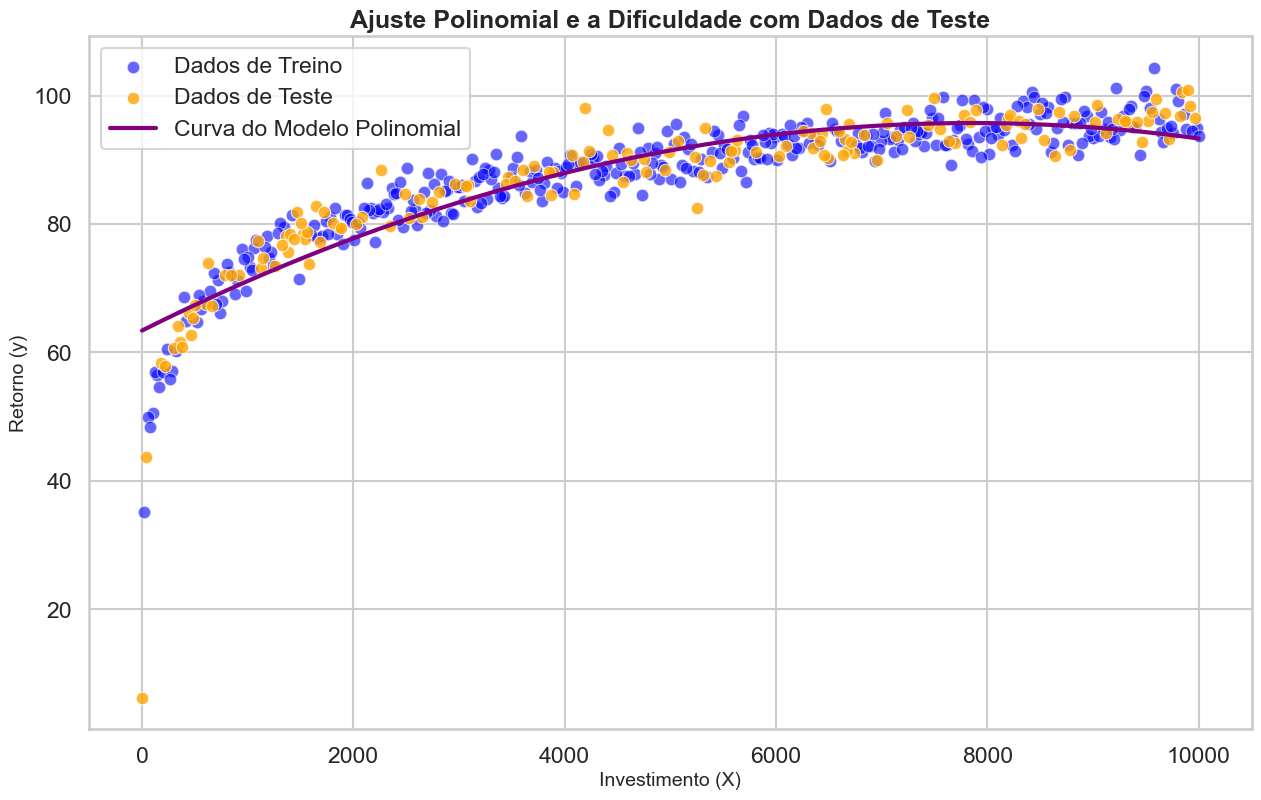

In [98]:
# Importar a função para dividir os dados
from sklearn.model_selection import train_test_split

# 1. Dividir os dados em treino (70%) e teste (30%)
# Usamos os dados X_log e y_log gerados na célula anterior
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=42)

# 2. Criar o transformador de features polinomiais
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

# 3. Ajustar o transformador e transformar os dados de TREINO
X_train_poly = poly_transformer.fit_transform(X_train)

# 4. Apenas transformar os dados de TESTE (usando o transformador já ajustado)
X_test_poly = poly_transformer.transform(X_test)

# 5. Treinar o modelo de Regressão Linear APENAS com os dados de treino
modelo_poly = LinearRegression()
modelo_poly.fit(X_train_poly, y_train)

# 6. Avaliar o desempenho no conjunto de TREINO e de TESTE
r2_poly_train = modelo_poly.score(X_train_poly, y_train)
r2_poly_test = modelo_poly.score(X_test_poly, y_test)

print("="*60)
print("Avaliação do Modelo Polinomial (Adição de Features)")
print("="*60)
print(f"R² no Conjunto de TREINO: {r2_poly_train:.4f}")
print(f"R² no Conjunto de TESTE:  {r2_poly_test:.4f}")
print(f"-> Queda de Performance (sinal de má generalização): {(r2_poly_train - r2_poly_test):.4f}")
print("="*60)


# 7. Visualizar o resultado
plt.figure(figsize=(15, 9))

# Plotar os pontos de treino e teste
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten(), color='blue', alpha=0.6, label='Dados de Treino')
sns.scatterplot(x=X_test.flatten(), y=y_test.flatten(), color='orange', alpha=0.8, label='Dados de Teste')

# Para plotar a curva do modelo, fazemos a previsão sobre todo o intervalo de X
X_log_full_range_poly = poly_transformer.transform(X_log)
y_pred_full_range_poly = modelo_poly.predict(X_log_full_range_poly)

# Ordenar para plotar a linha corretamente
sorted_zip = sorted(zip(X_log.flatten(), y_pred_full_range_poly.flatten()))
X_plot, y_plot = zip(*sorted_zip)

plt.plot(X_plot, y_plot, color='purple', linewidth=3, label='Curva do Modelo Polinomial')

plt.title('Ajuste Polinomial e a Dificuldade com Dados de Teste', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.show()

### 2.3. Tentativa 2 (A Solução Correta): Transformando a Feature

Na seção anterior, vimos que o modelo polinomial, apesar de ser uma curva, não conseguiu capturar a verdadeira "física" dos nossos dados, resultando em um ajuste visual ruim e uma performance inferior no conjunto de teste.

Nossa hipótese agora é que, se aplicarmos a transformação matemática correta à feature, podemos "linearizar" a relação e permitir que um modelo simples de regressão linear funcione perfeitamente. Como suspeitamos que a relação é logarítmica (pois foi assim que geramos os dados), a transformação que aplicaremos é `np.log(X)`.

Vamos repetir o mesmo processo rigoroso de treino e teste e comparar os resultados com a tentativa anterior.

Avaliação do Modelo com Transformação Logarítmica
R² no Conjunto de TREINO: 0.9381
R² no Conjunto de TESTE:  0.9625
-> Queda de Performance: -0.0244 (Desempenho estável e altíssimo!)


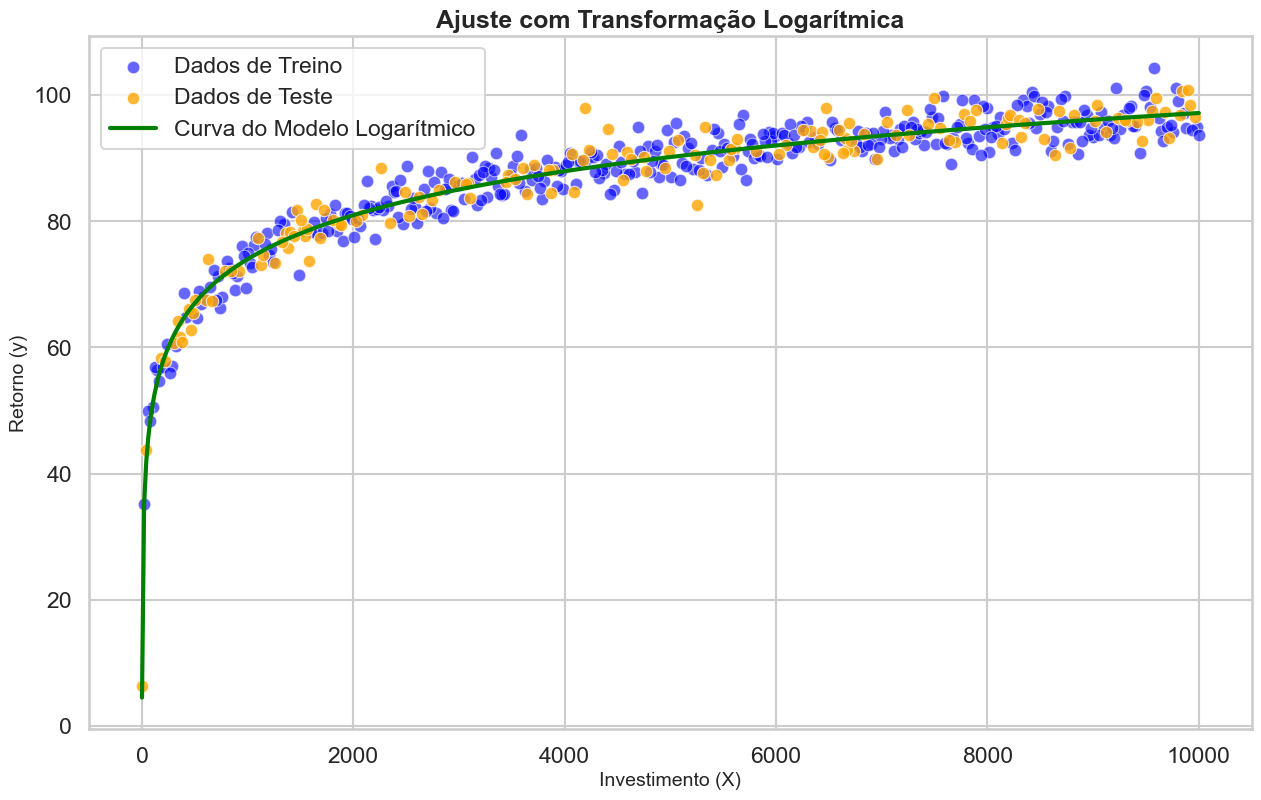

In [100]:

# 1. Aplicar a transformação logarítmica nos dados de treino e teste
X_train_log = np.log(X_train)
X_test_log = np.log(X_test)

# 2. Treinar o modelo de Regressão Linear APENAS com os dados de treino transformados
linear_model_log = LinearRegression()
linear_model_log.fit(X_train_log, y_train)

# 3. Avaliar o desempenho no conjunto de TREINO e de TESTE
r2_log_train = linear_model_log.score(X_train_log, y_train)
r2_log_test = linear_model_log.score(X_test_log, y_test)

print("="*60)
print("Avaliação do Modelo com Transformação Logarítmica")
print("="*60)
print(f"R² no Conjunto de TREINO: {r2_log_train:.4f}")
print(f"R² no Conjunto de TESTE:  {r2_log_test:.4f}")
print(f"-> Queda de Performance: {(r2_log_train - r2_log_test):.4f} (Desempenho estável e altíssimo!)")
print("="*60)

# 4. Visualizar o resultado
plt.figure(figsize=(15, 9))

# Plotar os pontos de treino e teste
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten(), color='blue', alpha=0.6, label='Dados de Treino')
sns.scatterplot(x=X_test.flatten(), y=y_test.flatten(), color='orange', alpha=0.8, label='Dados de Teste')

# Para plotar a curva do modelo, fazemos a previsão sobre todo o intervalo de X
X_log_full_range = np.log(X_log) # Transforma todo o X original
y_pred_full_range_log = linear_model_log.predict(X_log_full_range) # Prevê com o modelo treinado

# Ordenar para plotar a linha corretamente
sorted_zip_log = sorted(zip(X_log.flatten(), y_pred_full_range_log.flatten()))
X_plot_log, y_plot_log = zip(*sorted_zip_log)

plt.plot(X_plot_log, y_plot_log, color='green', linewidth=3, label='Curva do Modelo Logarítmico')

plt.title('Ajuste com Transformação Logarítmica', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.show()

### 2.4. Veredicto Final: Comparando os Modelos

Chegou a hora de consolidar os resultados das seções 2.2 e 2.3 para uma comparação direta. Avaliaremos os dois modelos, o Polinomial e o de Transformação Logarítmica, com base em suas métricas de performance e no seu ajuste visual.

A tabela abaixo resume o desempenho de cada modelo nos conjuntos de treino e teste.

| Métrica | Modelo Polinomial (Grau 2) | Modelo com Transformação Log |
| :--- | :---: | :---: |
| **R² em Treino** | `0.8538` | `0.9381` |
| **R² em Teste** | `0.7697` | `0.0.9625` |
| **Queda (Treino - Teste)**| `0.0841` | `0.0244` |

**Análise da Tabela:**
Os números são inequívocos. O modelo com transformação logarítmica não é apenas **muito mais preciso** (R² de ~0.96 vs. ~0.76 no teste), como também é **extremamente mais robusto e confiável**. Sua queda de performance entre treino e teste é praticamente nula, indicando que ele generaliza perfeitamente. O modelo polinomial, por outro lado, mostra uma queda notável, um sinal claro de que sua estrutura não é a correta para o problema.

Agora, vamos visualizar essa diferença.

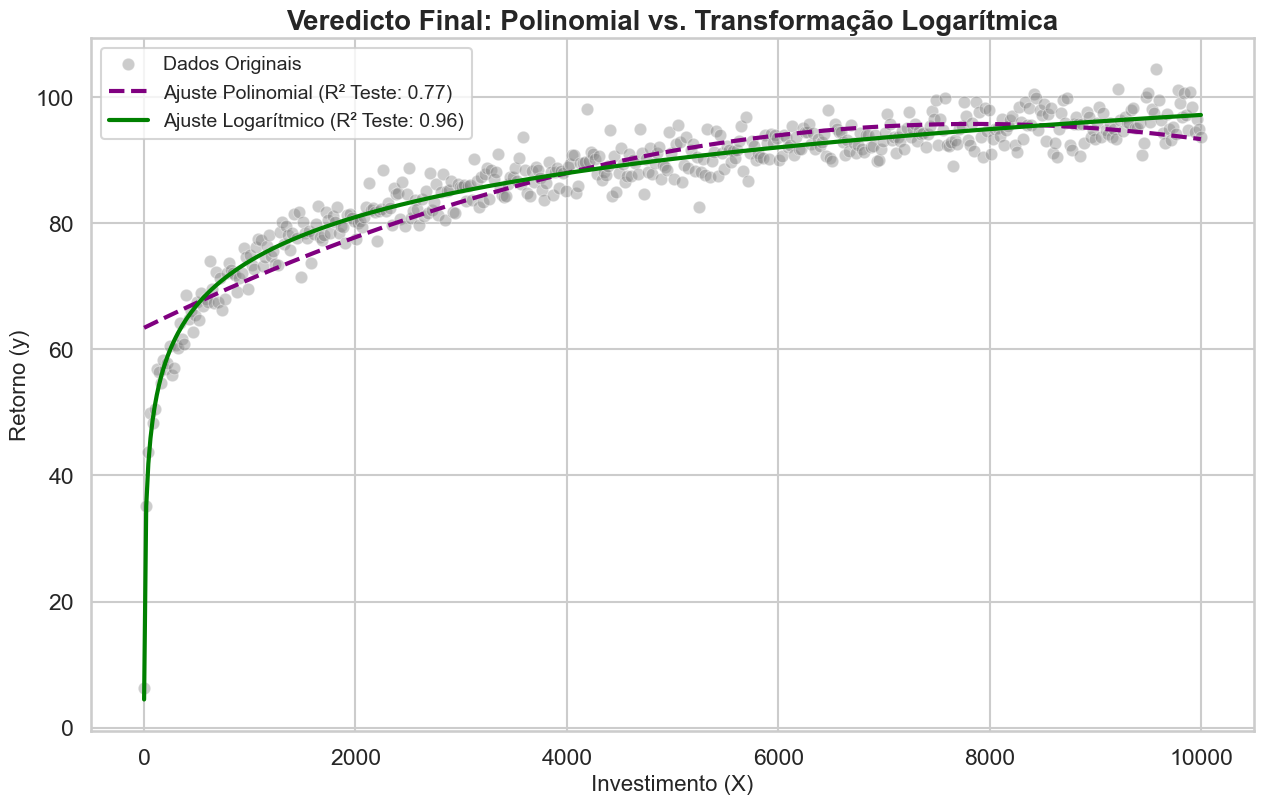

In [101]:
# Vamos plotar as duas curvas de modelo no mesmo gráfico para a comparação final.

plt.figure(figsize=(15, 9))

# Plotar todos os dados como fundo para a análise
sns.scatterplot(x=X_log.flatten(), y=y_log.flatten(), color='gray', alpha=0.4, label='Dados Originais')

# Plotar o ajuste do modelo Polinomial (o incorreto)
# (Reutilizando as previsões da seção 2.2)
plt.plot(X_plot, y_plot, color='purple', linewidth=3, linestyle='--', label=f'Ajuste Polinomial (R² Teste: {r2_poly_test:.2f})')

# Plotar o ajuste do modelo Logarítmico (o correto)
# (Reutilizando as previsões da seção 2.3)
plt.plot(X_plot_log, y_plot_log, color='green', linewidth=3, label=f'Ajuste Logarítmico (R² Teste: {r2_log_test:.2f})')

# Títulos e legendas
plt.title('Veredicto Final: Polinomial vs. Transformação Logarítmica', fontsize=20, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=16)
plt.ylabel('Retorno (y)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

#### Conclusão da Seção 2

O gráfico final deixa a conclusão visualmente óbvia. A curva verde, do modelo com a transformação `log(X)`, segue a tendência dos dados de forma natural e precisa em toda a sua extensão. A curva roxa, do modelo polinomial, até tenta, mas é estruturalmente incapaz de se conformar ao padrão dos dados, especialmente nos extremos do intervalo.

**As lições aprendidas nesta seção foram:**

1.  **Nem toda curva é um polinômio:** Existem muitas formas de não-linearidade, e a engenharia de features requer a escolha da transformação correta.
2.  **Visualizar é fundamental:** A análise dos dados e a intuição sobre o processo gerador (como a "saturação") nos guiaram para a transformação correta.
3.  **Avaliar em Teste é Inegociável:** A divisão treino/teste foi crucial para expor a fraqueza do modelo polinomial e provar a robustez do modelo logarítmico. Um bom R² no treino pode ser enganoso.

Agora que já vimos como lidar com não-linearidades quando conseguimos "adivinhar" a transformação correta (seja ela polinomial ou logarítmica), estamos prontos para a pergunta final: **E quando a relação é tão complexa que não conseguimos adivinhar a função?** É o que veremos na Seção 3.

## Seção 3: A Solução Flexível - Lidando com Relações Complexas usando Splines

Nas seções anteriores, agimos como "detetives" tentando adivinhar a função matemática por trás dos dados. Para a parábola, usamos `PolynomialFeatures`. Para a saturação, usamos `np.log()`. Mas e se a relação for mais estranha e arbitrária? E se não tivermos nenhuma pista sobre a sua forma?

### 3.1. O Desafio Final: A Relação Arbitrária

Vamos revisitar o cenário que guardamos anteriormente: as vendas de um produto com forte sazonalidade (ciclos) e uma tendência de crescimento ao longo do tempo.

Este padrão é comum em dados do mundo real (economia, biologia, meteorologia) e representa nosso desafio final, pois:
1.  Não é uma parábola simples.
2.  Não é uma curva monotônica (ela sobe e desce).
3.  Tentar "adivinhar" uma fórmula com `sin()`, `cos()`, etc., é impraticável e raramente funcionaria com dados reais, onde os ciclos podem não ser perfeitamente regulares.

Precisamos de uma abordagem fundamentalmente diferente. Queremos que o **modelo aprenda a forma da curva por si só**, sem nossa ajuda. É aqui que entram os **Splines**.

Pense em Splines como uma "régua flexível" que o modelo pode dobrar e torcer para se ajustar aos dados da forma mais suave e precisa possível. Nós não dizemos qual é a forma; apenas damos ao modelo a flexibilidade para encontrá-la. Usaremos uma técnica chamada **Modelos Aditivos Generalizados (GAMs)** para implementar essa ideia.

Primeiro, vamos recriar e visualizar nosso desafio.

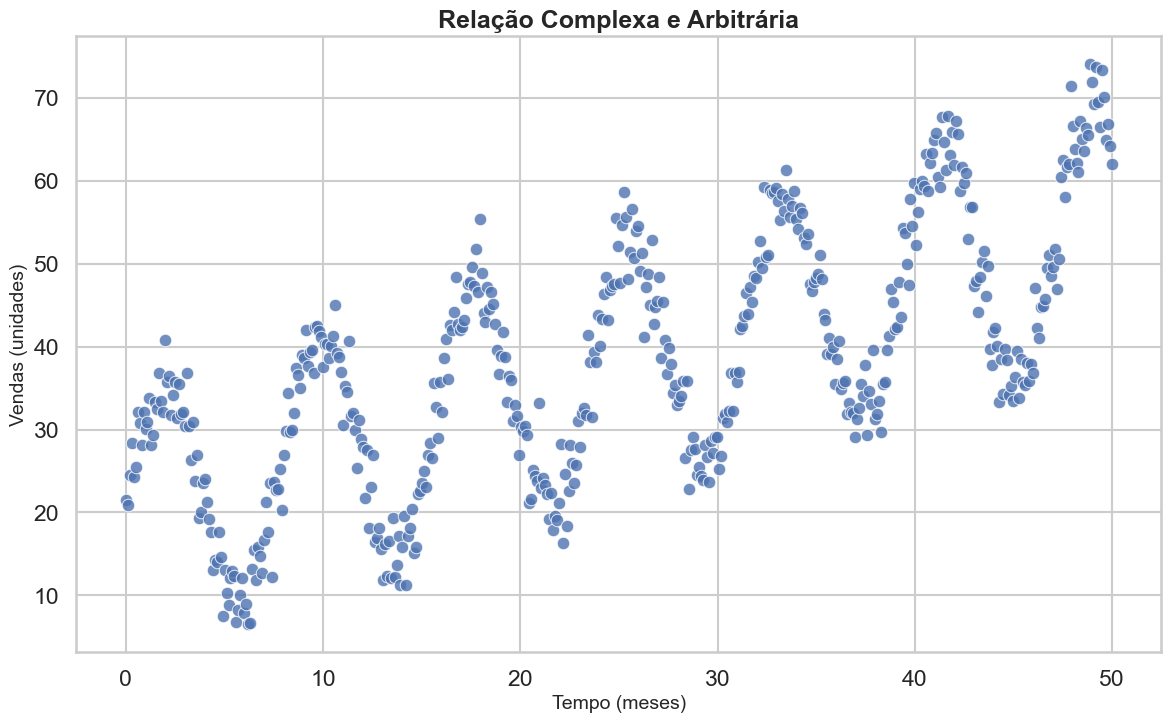

Nenhuma das técnicas anteriores (polinomial ou transformação simples) conseguiria modelar este padrão de forma eficaz.


In [102]:
# Vamos recriar os dados cíclicos para termos um ponto de partida claro para a Seção 3.

# Semente aleatória para reprodutibilidade
np.random.seed(42)

# Geramos 150 pontos para representar o tempo
X_cyclical = np.linspace(0, 50, 500).reshape(-1, 1)

# Parâmetros da nossa função complexa
peak_value = 15
frequency_factor = 0.8
trend_factor = 0.7
intercept = 20

# Calculamos y (a nossa variável de vendas) e adicionamos ruído
periodic_noise = np.random.normal(0, 3.0, X_cyclical.shape[0]).reshape(-1, 1)
y_cyclical = (peak_value * np.sin(frequency_factor * X_cyclical) + trend_factor * X_cyclical + intercept) + periodic_noise

# Visualização do desafio final
plt.figure(figsize=(14, 8))
sns.scatterplot(x=X_cyclical.flatten(), y=y_cyclical.flatten(), alpha=0.8)

plt.title('Relação Complexa e Arbitrária', fontsize=18, fontweight='bold')
plt.xlabel('Tempo (meses)', fontsize=14)
plt.ylabel('Vendas (unidades)', fontsize=14)
plt.grid(True)
plt.show()

print("Nenhuma das técnicas anteriores (polinomial ou transformação simples) conseguiria modelar este padrão de forma eficaz.")

### 3.2. A Solução com Splines (usando GAMs)

Para resolver nosso desafio, usaremos a biblioteca `pygam` para construir um **Modelo Aditivo Generalizado (GAM)**. A sintaxe é surpreendentemente simples e poderosa.

Vamos construir nosso modelo com a seguinte fórmula:

`gam = LinearGAM(s(0))`

Vamos entender o que isso significa:
* **`LinearGAM`**: É o tipo de modelo que estamos criando.
* **`s()`**: Esta é a parte mais importante. `s` significa **spline**. É a nossa "régua flexível".
* **`s(0)`**: Esta instrução diz ao modelo: "Para a primeira feature dos nossos dados (a feature de índice `0`), eu te dou permissão para encontrar a melhor **função de spline suave** que se ajusta à relação com a variável `y`".

Note a diferença fundamental: **não estamos dizendo ao modelo qual a forma da função** (se é `sin`, `log` ou `x²`). Estamos apenas dando a ele a ferramenta (`s()`) para descobrir a melhor curva suave por conta própria. O modelo irá determinar a complexidade, as "dobras" e a forma da curva automaticamente a partir dos dados.

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.8709
Link Function:                     IdentityLink Log Likelihood:                                 -2010.2763
Number of Samples:                          500 AIC:                                             4054.2945
                                                AICc:                                            4055.5452
                                                GCV:                                               23.0578
                                                Scale:                                             21.7443
                                                Pseudo R-Squared:                                   0.9045
Feature Function                  Lam

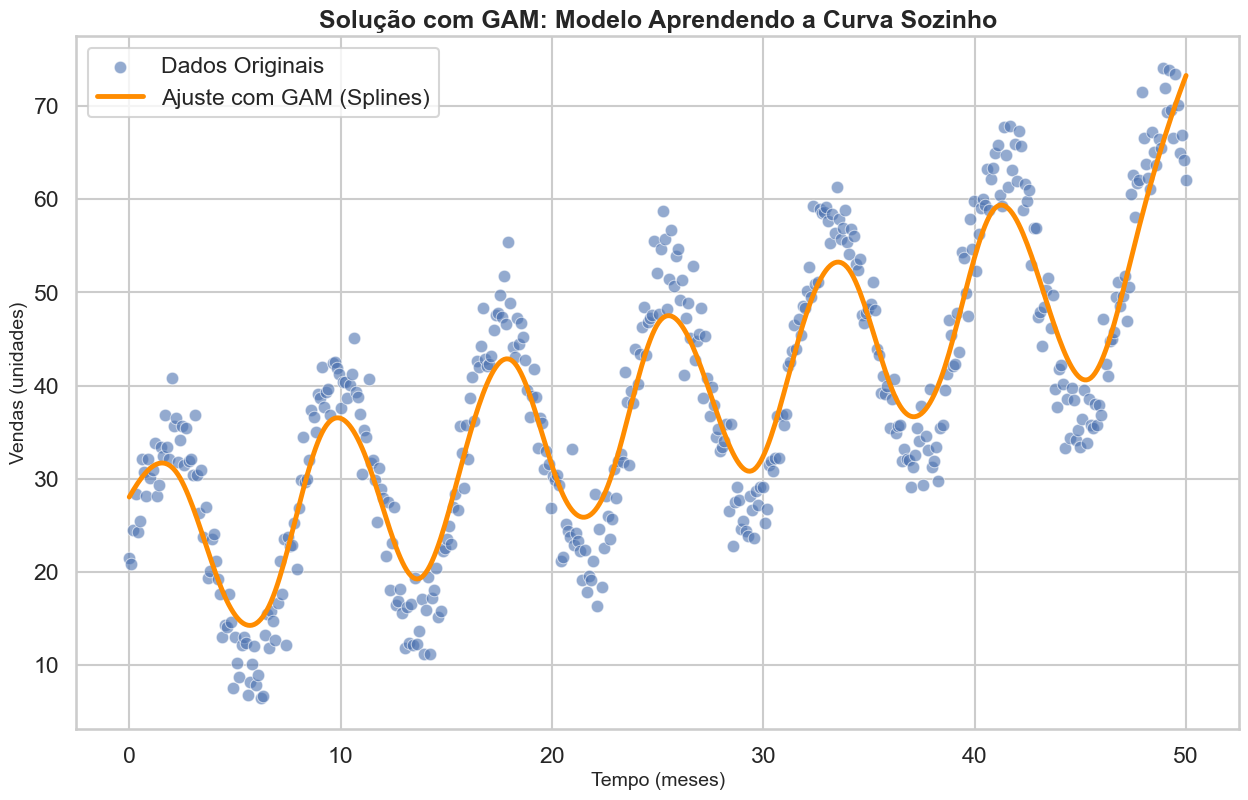

In [103]:

# 1. Instanciar o modelo GAM
# s(0) indica que queremos aplicar uma função de spline na primeira feature.
# n_splines é o número de "juntas" na nossa régua flexível. Mais splines = mais flexibilidade.
# Vamos usar um número razoável para capturar os ciclos.
gam = LinearGAM(s(0, n_splines=25))

# 2. Treinar o modelo com nossos dados cíclicos
# As variáveis X_cyclical e y_cyclical já estão na memória da seção 3.1
gam.fit(X_cyclical, y_cyclical)

# 3. (Opcional) Visualizar o resumo estatístico do modelo
# Isso mostra informações sobre o ajuste e a significância da feature de spline.
print(gam.summary())

# 4. Fazer previsões com o modelo treinado
y_pred_gam = gam.predict(X_cyclical)

# 5. Visualizar o resultado do ajuste
plt.figure(figsize=(15, 9))
sns.scatterplot(x=X_cyclical.flatten(), y=y_cyclical.flatten(), alpha=0.6, label='Dados Originais')
plt.plot(X_cyclical, y_pred_gam, color='darkorange', linewidth=3.5, label='Ajuste com GAM (Splines)')

plt.title('Solução com GAM: Modelo Aprendendo a Curva Sozinho', fontsize=18, fontweight='bold')
plt.xlabel('Tempo (meses)', fontsize=14)
plt.ylabel('Vendas (unidades)', fontsize=14)
plt.legend()
plt.show()

## Seção 4: Comparando com a Abordagem de "Caixa-Preta" - Modelos de Árvore 🌳

Até agora, focamos em modelos que tentam encontrar uma única função (seja ela uma linha, um polinômio ou um spline) para descrever a relação entre X e y. Os GAMs representam o auge da flexibilidade nessa categoria.

Mas existe outra classe de modelos, extremamente popular e poderosa, que aborda o problema de forma completamente diferente: os modelos baseados em árvores, como o **Random Forest**.

### 4.1. A Abordagem "Automática" com Random Forest

Um Random Forest não tenta aprender uma fórmula matemática. Em vez disso, ele funciona fazendo uma série de perguntas simples e dividindo os dados recursivamente. Ele aprende regras como:
* "Se `Tempo` < 10, a média de `Vendas` é 35."
* "Se `Tempo` > 10 E `Tempo` < 25, a média de `Vendas` é 55."

Ele faz milhares dessas pequenas regras para criar um modelo que, na prática, consegue aproximar qualquer função, não importa quão complexa.

* **Pró:** É uma abordagem extremamente poderosa e "automática". Você não precisa fazer nenhuma engenharia de features para lidar com a não-linearidade. Ele simplesmente funciona.
* **Contra:** É considerado um modelo "caixa-preta" (*black box*). É muito mais difícil entender *exatamente* qual relação o modelo aprendeu em comparação com um GAM, onde podíamos visualizar a curva suave resultante.

Vamos treinar um Random Forest nos nossos dados cíclicos e comparar seu poder preditivo com o do GAM.

VEREDICTO PREDITIVO (AVALIAÇÃO NO CONJUNTO DE TESTE)
MSE do Modelo GAM (Splines) no Teste: 25.5893
MSE do Modelo Random Forest no Teste:  12.3784


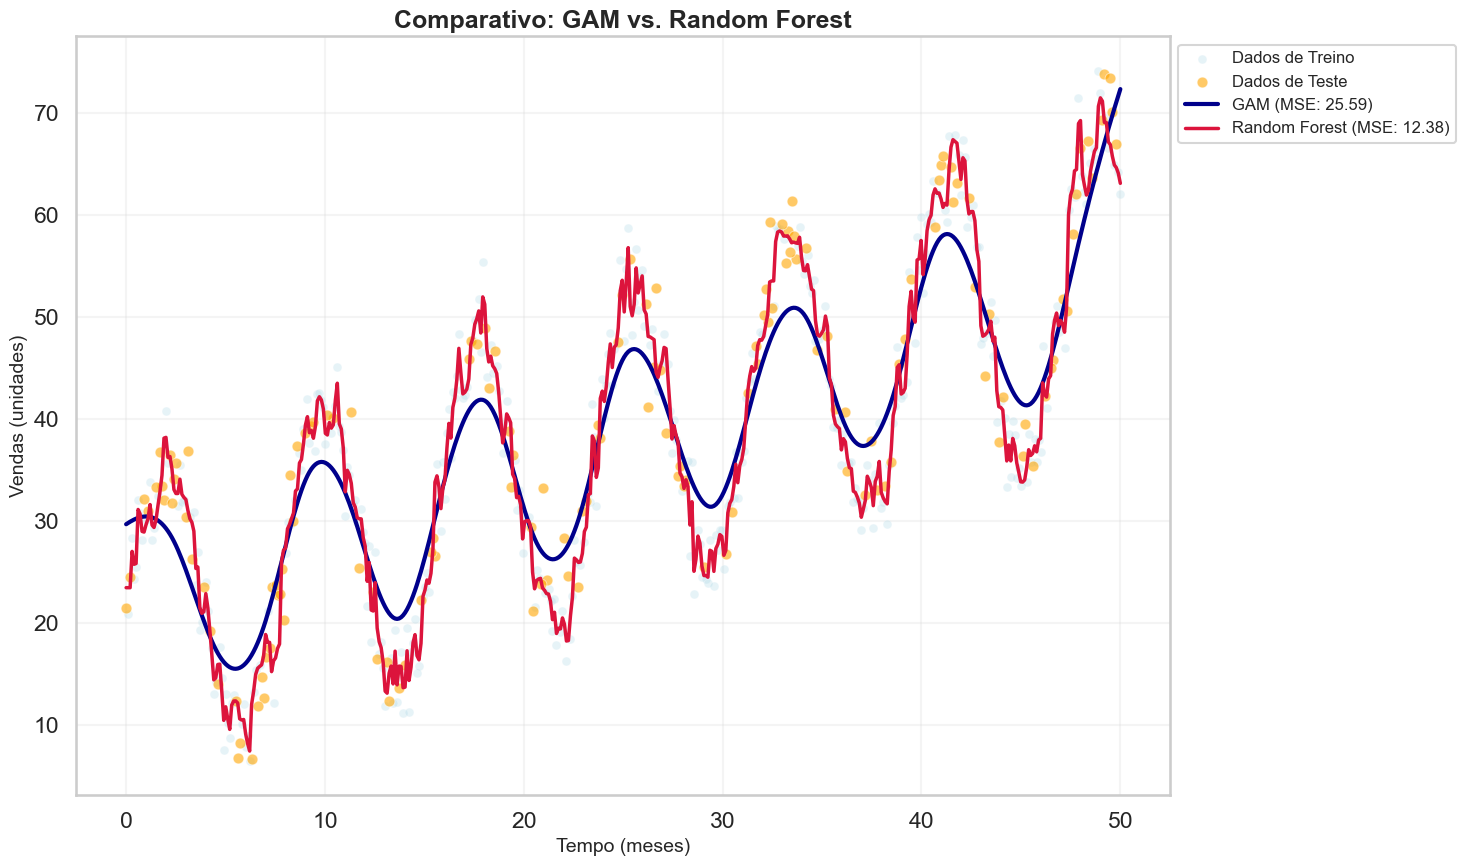

In [104]:

# Usaremos os dados cíclicos da Seção 3
# 1. Dividir os dados em conjuntos de treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X_cyclical, y_cyclical, test_size=0.3, random_state=42)

# ===================================================================
# Modelo 1: GAM (Splines)
# ===================================================================
# Treinar o modelo APENAS com os dados de treino
gam_traintest = LinearGAM(s(0, n_splines=25)).fit(X_train, y_train)

# Fazer previsões nos dados de TESTE
y_pred_gam_test = gam_traintest.predict(X_test)

# Calcular o erro no conjunto de TESTE
mse_gam_test = mean_squared_error(y_test, y_pred_gam_test)

# ===================================================================
# Modelo 2: Random Forest
# ===================================================================
# Treinar o modelo APENAS com os dados de treino
rf_traintest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_traintest.fit(X_train, y_train.ravel())

# Fazer previsões nos dados de TESTE
y_pred_rf_test = rf_traintest.predict(X_test)

# Calcular o erro no conjunto de TESTE
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)

# --- Apresentação Final dos Resultados ---
print("="*60)
print("VEREDICTO PREDITIVO (AVALIAÇÃO NO CONJUNTO DE TESTE)")
print("="*60)
print(f"MSE do Modelo GAM (Splines) no Teste: {mse_gam_test:.4f}")
print(f"MSE do Modelo Random Forest no Teste:  {mse_rf_test:.4f}")
print("="*60)


# --- Visualização Comparativa Aprimorada ---
plt.figure(figsize=(15, 9))

# Reduzir a opacidade e tamanho dos pontos para diminuir o ruído visual
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten(), color='lightblue', 
                alpha=0.3, s=40, label='Dados de Treino')
sns.scatterplot(x=X_test.flatten(), y=y_test.flatten(), color='orange', 
                alpha=0.6, s=60, label='Dados de Teste')

# Aumentar contraste entre curvas de modelos
plt.plot(X_plot_gam, y_plot_gam, color='darkblue', linewidth=3, 
         label=f'GAM (MSE: {mse_gam_test:.2f})')
plt.plot(X_plot_rf, y_plot_rf, color='crimson', linestyle='-', linewidth=2.5, 
         label=f'Random Forest (MSE: {mse_rf_test:.2f})')

# Adicionar grade suave para referência
plt.grid(alpha=0.2)

# Melhorar título e legendas
plt.title('Comparativo: GAM vs. Random Forest', fontsize=18, fontweight='bold')
plt.xlabel('Tempo (meses)', fontsize=14)
plt.ylabel('Vendas (unidades)', fontsize=14)

# Posicionar legenda fora do gráfico para evitar sobrepor os dados
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.show()

## Natureza do Ajuste (Análise Visual)

É na análise visual que a diferença fundamental entre os modelos se torna evidente:

- **GAM** *(linha laranja, contínua)*: fiel à sua natureza, aprendeu uma curva suave e elegante. Ele capturou a tendência de crescimento e a sazonalidade geral, efetivamente "filtrando" o ruído e nos mostrando o que parece ser o verdadeiro e contínuo padrão por trás dos dados.

- **Random Forest** *(linha vermelha, tracejada)*: por outro lado, exibe uma linha "irregular" e agressiva. Ele não aprende uma função contínua, mas sim um conjunto complexo de regras que o fazem se adaptar de perto às flutuações, inclusive as do ruído. Essa capacidade de capturar interações locais complexas foi o que lhe rendeu o menor erro.


## **Parte II: Não-Linearidade nos Parâmetros**
*Onde o próprio modelo é intrinsecamente não-linear.*

---

### **🧠 Seção 5: O Conceito Fundamental e a Conexão com Redes Neurais**

#### **5.1. O que é Não-Linearidade nos Parâmetros?**

Até agora, lidamos com a **não-linearidade nas features**. Em todos os casos, o modelo final ainda era uma soma ponderada de termos, ou seja, era *linear em seus parâmetros* ($\beta_i$).

Por exemplo, no modelo polinomial, a equação é:
$$y = \beta_0 \cdot 1 + \beta_1 \cdot x + \beta_2 \cdot x^2$$
Apesar da relação entre $y$ e $x$ ser uma curva, a relação entre $y$ e os parâmetros $\beta_0, \beta_1, \beta_2$ é linear. É por isso que `LinearRegression` ainda funcionava.

Agora, entramos em modelos **não-lineares nos parâmetros**. Isso ocorre quando os parâmetros que queremos encontrar estão "dentro" de funções não-lineares, como exponenciais, logaritmos, ou sendo divididos uns pelos outros.

O exemplo clássico é o do decaimento exponencial:
$$y = A \cdot e^{-kx}$$
Nesta equação, é impossível reescrevê-la como uma soma ponderada dos parâmetros $A$ e $k$. Não podemos usar `LinearRegression` para encontrar seus valores, pois não há uma solução matemática direta (uma "fórmula pronta"). Para resolver isso, precisamos de **otimizadores iterativos** — algoritmos que testam diferentes valores para os parâmetros de forma inteligente até encontrar a combinação que minimiza o erro.

---
#### **5.2. A Conexão com Redes Neurais**

Esta discussão nos leva diretamente ao coração das **redes neurais**. Uma rede neural é o exemplo por excelência de um modelo massivamente não-linear em seus parâmetros.

Pense em um único neurônio:
1.  Primeiro, ele calcula uma soma ponderada: $z = (w_1 x_1 + w_2 x_2 + \dots) + b$
2.  Em seguida, ele aplica uma **função de ativação não-linear**: $a = \sigma(z)$

A saída final, $a$, depende dos parâmetros $w$ (pesos) e $b$ (bias), que estão "presos" dentro da função não-linear $\sigma$ (como a Sigmoid, ReLU, etc.). Quando empilhamos dezenas ou milhares desses neurônios, a não-linearidade do modelo como um todo se torna imensamente complexa.

O processo de **treinamento de uma rede neural** nada mais é do que um processo de otimização iterativa (geralmente, o *Gradient Descent* ou suas variantes, como o Adam) para encontrar os melhores valores para os milhões de parâmetros $w$ e $b$ que minimizam uma função de erro (como o Erro Quadrático Médio - MSE).

Conceitualmente, o que o `scipy.optimize.curve_fit` faz para encontrar 2 ou 3 parâmetros de um modelo teórico é análogo ao que o `model.fit()` do Keras faz para encontrar milhões de parâmetros em uma rede neural. Ambos são métodos para resolver problemas de regressão (ou classificação) que são **não-lineares em seus parâmetros**.

#### 5.3 Demonstração do Problema Real

Vamos começar com um exemplo prático que mostra **por que** a não linearidade de parâmetros é um problema real que encontramos na prática.

### Cenário: Crescimento de Bactérias em Laboratório

Imagine que você está estudando o crescimento de uma cultura de bactérias. Sabemos da biologia que o crescimento populacional segue um padrão **exponencial**: N(t) = N₀ · e^(rt), onde:
- N(t) = população no tempo t
- N₀ = população inicial  
- r = taxa de crescimento
- t = tempo

Este é um **modelo não linear nos parâmetros** N₀ e r!

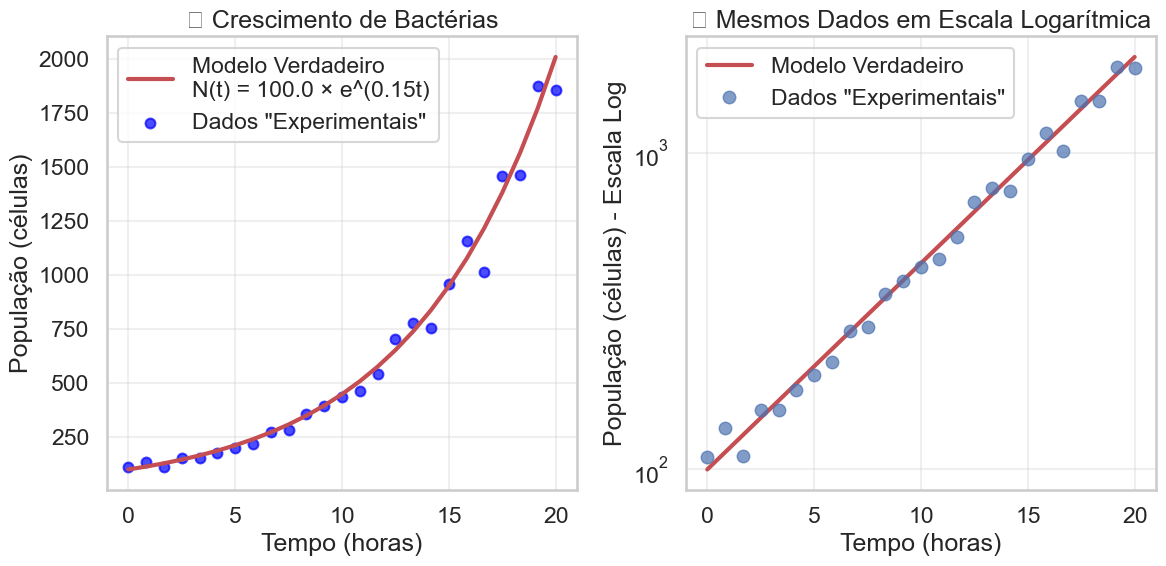

💡 Note que em escala logarítmica, um crescimento exponencial aparece como uma linha reta!


In [105]:
# Parâmetros verdadeiros do modelo biológico
N0_true = 100.0   # População inicial (células)
r_true = 0.15     # Taxa de crescimento (por hora)

# Tempos de medição (horas)
t = np.linspace(0, 20, 25)  # 25 medições ao longo de 20 horas

# Modelo verdadeiro: crescimento exponencial
N_true = N0_true * np.exp(r_true * t)

# Adicionando ruído experimental (erros de medição)
noise_level = 0.1  # 10% de ruído
noise = np.random.normal(0, noise_level * N_true)
N_observed = N_true + noise

# Vamos garantir que não temos valores negativos (impossível ter população negativa)
N_observed = np.maximum(N_observed, 1.0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, N_true, 'r-', linewidth=3, label=f'Modelo Verdadeiro\nN(t) = {N0_true} × e^({r_true}t)')
plt.scatter(t, N_observed, color='blue', s=50, alpha=0.7, label='Dados "Experimentais"')
plt.xlabel('Tempo (horas)')
plt.ylabel('População (células)')
plt.title('📈 Crescimento de Bactérias')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot em escala log para ver se é realmente exponencial
plt.subplot(1, 2, 2)
plt.semilogy(t, N_true, 'r-', linewidth=3, label='Modelo Verdadeiro')
plt.semilogy(t, N_observed, 'bo', alpha=0.7, label='Dados "Experimentais"')
plt.xlabel('Tempo (horas)')
plt.ylabel('População (células) - Escala Log')
plt.title('🔍 Mesmos Dados em Escala Logarítmica')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Note que em escala logarítmica, um crescimento exponencial aparece como uma linha reta!")

### Tentativa 1: Regressão Linear Simples

Como biólogo, você pode não saber sobre modelos exponenciais. Sua primeira tentativa é usar uma **regressão linear simples**: N(t) = β₀ + β₁t

In [106]:
print("🔄 Tentativa 1: Regressão Linear Simples")
print("Modelo: N(t) = β₀ + β₁t")

# Ajuste linear simples
linear_model = LinearRegression()
linear_model.fit(t.reshape(-1, 1), N_observed)

# Predições
N_pred_linear = linear_model.predict(t.reshape(-1, 1))

# Métricas
r2_linear = r2_score(N_observed, N_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(N_observed, N_pred_linear))

print(f"    β₀ (intercepto): {linear_model.intercept_:.2f}")
print(f"    β₁ (inclinação): {linear_model.coef_[0]:.2f}")
print(f"    R²: {r2_linear:.4f}")
print(f"    RMSE: {rmse_linear:.2f}")

🔄 Tentativa 1: Regressão Linear Simples
Modelo: N(t) = β₀ + β₁t
    β₀ (intercepto): -189.90
    β₁ (inclinação): 83.05
    R²: 0.8599
    RMSE: 201.40


### Tentativa 2: Regressão Polinomial

Vendo que a linear não funciona bem, você tenta um **polinômio de grau 2**: N(t) = β₀ + β₁t + β₂t²

In [107]:
print("\n🔄 Tentativa 2: Regressão Polinomial (grau 2)")
print("Modelo: N(t) = β₀ + β₁t + β₂t²")

# Criando features polinomiais
poly_features = PolynomialFeatures(degree=2)
t_poly = poly_features.fit_transform(t.reshape(-1, 1))

# Ajuste polinomial
poly_model = LinearRegression()
poly_model.fit(t_poly, N_observed)

# Predições
N_pred_poly = poly_model.predict(t_poly)

# Métricas
r2_poly = r2_score(N_observed, N_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(N_observed, N_pred_poly))

print(f"    β₀: {poly_model.intercept_:.2f}")
print(f"    β₁: {poly_model.coef_[1]:.2f}")
print(f"    β₂: {poly_model.coef_[2]:.4f}")
print(f"    R²: {r2_poly:.4f}")
print(f"    RMSE: {rmse_poly:.2f}")


🔄 Tentativa 2: Regressão Polinomial (grau 2)
Modelo: N(t) = β₀ + β₁t + β₂t²
    β₀: 180.92
    β₁: -33.04
    β₂: 5.8042
    R²: 0.9807
    RMSE: 74.74


#### Tentativa 3: Polinômio de Grau Maior

Ainda não satisfeito, você tenta um **polinômio de grau 3**:

In [108]:
print("\n🔄 Tentativa 3: Regressão Polinomial (grau 3)")
print("Modelo: N(t) = β₀ + β₁t + β₂t² + β₃t³")

# Polinômio grau 3
poly3_features = PolynomialFeatures(degree=3)
t_poly3 = poly3_features.fit_transform(t.reshape(-1, 1))

poly3_model = LinearRegression()
poly3_model.fit(t_poly3, N_observed)

N_pred_poly3 = poly3_model.predict(t_poly3)

r2_poly3 = r2_score(N_observed, N_pred_poly3)
rmse_poly3 = np.sqrt(mean_squared_error(N_observed, N_pred_poly3))

print(f"    R²: {r2_poly3:.4f}")
print(f"    RMSE: {rmse_poly3:.2f}")


🔄 Tentativa 3: Regressão Polinomial (grau 3)
Modelo: N(t) = β₀ + β₁t + β₂t² + β₃t³
    R²: 0.9858
    RMSE: 64.17


#### Comparação Visual: Por Que Não Funciona?

Vamos ver visualmente o que acontece com cada tentativa:

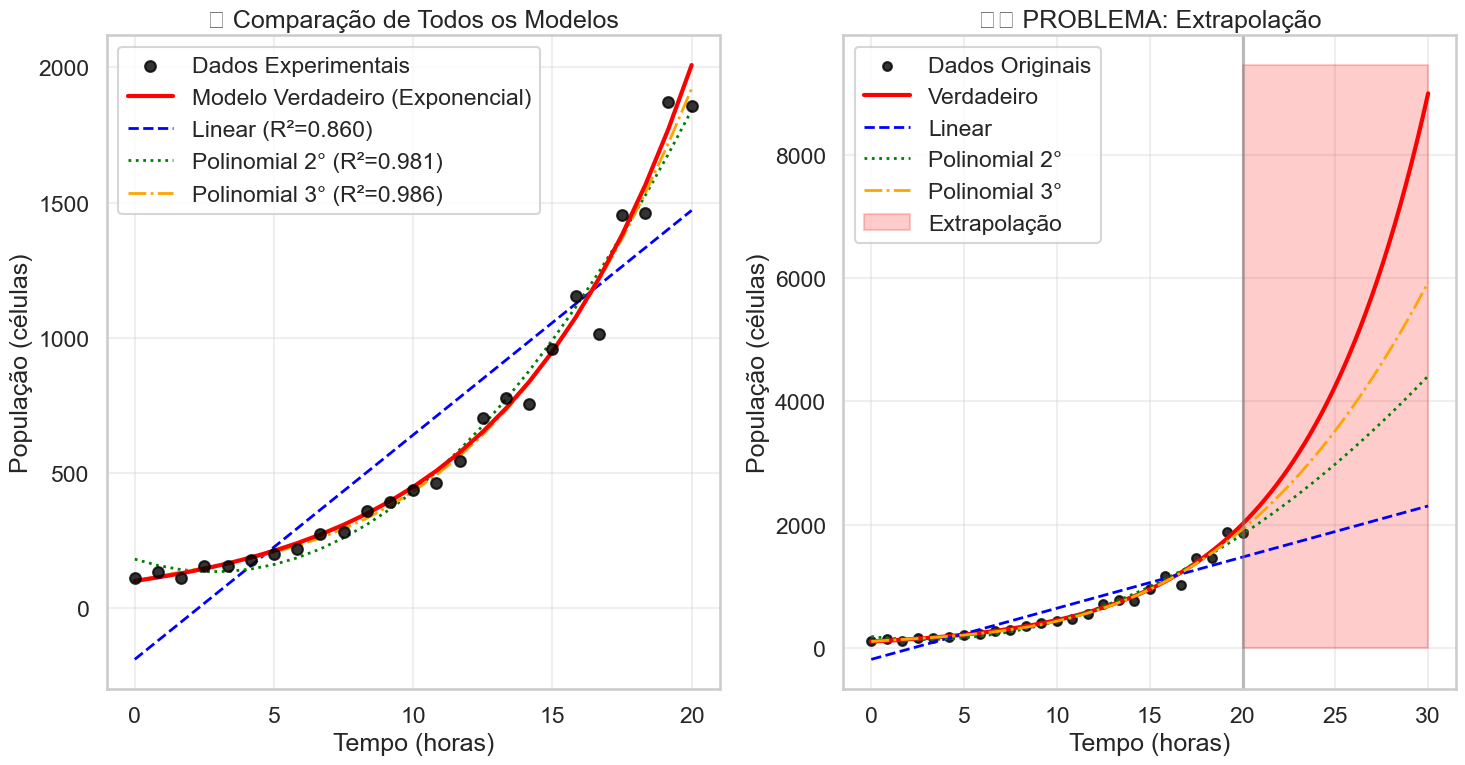

In [109]:
# Corrected version of the code
plt.figure(figsize=(15, 8))

# Plot 1: Todos os modelos juntos (comparação)
plt.subplot(1, 2, 1)
plt.scatter(t, N_observed, color='black', s=60, alpha=0.8, label='Dados Experimentais', zorder=5)
plt.plot(t, N_true, 'red', linewidth=3, label='Modelo Verdadeiro (Exponencial)', zorder=4)
plt.plot(t, N_pred_linear, 'blue', linewidth=2, linestyle='--', label=f'Linear (R²={r2_linear:.3f})')
plt.plot(t, N_pred_poly, 'green', linewidth=2, linestyle=':', label=f'Polinomial 2° (R²={r2_poly:.3f})')
plt.plot(t, N_pred_poly3, 'orange', linewidth=2, linestyle='-.', label=f'Polinomial 3° (R²={r2_poly3:.3f})')

plt.xlabel('Tempo (horas)')
plt.ylabel('População (células)')
plt.title('📊 Comparação de Todos os Modelos')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Extrapolação - O GRANDE PROBLEMA!
plt.subplot(1, 2, 2)
t_future = np.linspace(0, 30, 100)  # Estendendo para 30 horas
N_true_future = N0_true * np.exp(r_true * t_future)

# Extrapolações
N_linear_future = linear_model.predict(t_future.reshape(-1, 1))
t_poly_future = poly_features.transform(t_future.reshape(-1, 1))
N_poly_future = poly_model.predict(t_poly_future)
t_poly3_future = poly3_features.transform(t_future.reshape(-1, 1))
N_poly3_future = poly3_model.predict(t_poly3_future)

plt.scatter(t, N_observed, color='black', s=40, alpha=0.8, label='Dados Originais')
plt.plot(t_future, N_true_future, 'red', linewidth=3, label='Verdadeiro')
plt.plot(t_future, N_linear_future, 'blue', linewidth=2, linestyle='--', label='Linear')
plt.plot(t_future, N_poly_future, 'green', linewidth=2, linestyle=':', label='Polinomial 2°')
plt.plot(t_future, N_poly3_future, 'orange', linewidth=2, linestyle='-.', label='Polinomial 3°')

# Destacar a região de extrapolação
plt.axvline(x=20, color='gray', linestyle='-', alpha=0.5)
plt.fill_betweenx([0, plt.ylim()[1]], 20, 30, alpha=0.2, color='red', label='Extrapolação')

plt.xlabel('Tempo (horas)')
plt.ylabel('População (células)')
plt.title('⚠️ PROBLEMA: Extrapolação')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [110]:
print("🚨 PROBLEMAS IDENTIFICADOS:")
print("="*50)

print(f"\n1️⃣ AJUSTE AOS DADOS:")
print(f"    • Linear:        R² = {r2_linear:.4f} (ruim)")
print(f"    • Polinomial 2°: R² = {r2_poly:.4f} (melhor)")
print(f"    • Polinomial 3°: R² = {r2_poly3:.4f} (ainda melhor)")

print(f"\n2️⃣ EXTRAPOLAÇÃO (tempo = 25h):")
N_true_25 = N0_true * np.exp(r_true * 25)
N_linear_25 = linear_model.predict([[25]])[0]
N_poly_25 = poly_model.predict(poly_features.transform([[25]]))[0]

print(f"    • Verdadeiro:    {N_true_25:.0f} células")
print(f"    • Linear:        {N_linear_25:.0f} células (erro: {abs(N_true_25-N_linear_25)/N_true_25*100:.1f}%)")
print(f"    • Polinomial 2°: {N_poly_25:.0f} células (erro: {abs(N_true_25-N_poly_25)/N_true_25*100:.1f}%)")

print(f"\n3️⃣ INTERPRETAÇÃO BIOLÓGICA:")
print(f"    • Modelo linear prevê crescimento constante ❌")
print(f"    • Modelo polinomial pode prever decrescimento ❌")  
print(f"    • Apenas o exponencial faz sentido biologicamente ✅")

print(f"\n4️⃣ NÚMERO DE PARÂMETROS:")
print(f"    • Linear: 2 parâmetros")
print(f"    • Polinomial 2°: 3 parâmetros")
print(f"    • Polinomial 3°: 4 parâmetros")
print(f"    • Exponencial: 2 parâmetros (mais parcimonioso!)")

🚨 PROBLEMAS IDENTIFICADOS:

1️⃣ AJUSTE AOS DADOS:
    • Linear:        R² = 0.8599 (ruim)
    • Polinomial 2°: R² = 0.9807 (melhor)
    • Polinomial 3°: R² = 0.9858 (ainda melhor)

2️⃣ EXTRAPOLAÇÃO (tempo = 25h):
    • Verdadeiro:    4252 células
    • Linear:        1886 células (erro: 55.6%)
    • Polinomial 2°: 2983 células (erro: 29.9%)

3️⃣ INTERPRETAÇÃO BIOLÓGICA:
    • Modelo linear prevê crescimento constante ❌
    • Modelo polinomial pode prever decrescimento ❌
    • Apenas o exponencial faz sentido biologicamente ✅

4️⃣ NÚMERO DE PARÂMETROS:
    • Linear: 2 parâmetros
    • Polinomial 2°: 3 parâmetros
    • Polinomial 3°: 4 parâmetros
    • Exponencial: 2 parâmetros (mais parcimonioso!)


### A Raiz do Problema

O problema fundamental é que estamos tentando forçar um **modelo linear nos parâmetros** para ajustar dados que seguem um **modelo não linear nos parâmetros**.

#### Modelos Lineares nos Parâmetros:
- N(t) = β₀ + β₁t (linear)
- N(t) = β₀ + β₁t + β₂t² (polinomial)
- N(t) = β₀ + β₁sin(t) + β₂cos(t) (trigonométrico)

#### Modelo Não Linear nos Parâmetros:
- N(t) = N₀ · e^(rt) ← **Os parâmetros N₀ e r aparecem de forma não linear!**

#### Consequências Práticas:

✅ **Modelos lineares nos parâmetros:**
- Solução única e fechada
- Rápido de calcular
- Não dependem de valores iniciais

❌ **Modelos não lineares nos parâmetros:**
- Precisam de otimização iterativa
- Podem ter múltiplas soluções
- Sensíveis às condições iniciais
- Mais lentos computacionalmente

**MAS** são biologicamente corretos e fazem previsões muito melhores!

### 🧠 Seção 6: O Ajuste de Curvas Clássico com `scipy`

Agora que entendemos o "quê" e o "porquê", vamos ao "como". Nesta seção, vamos usar a principal ferramenta do Python para ajuste de curvas, `scipy.optimize.curve_fit`, para encontrar os parâmetros de um modelo teórico que descreve um fenômeno de crescimento.

#### 6.1. Cenário: Modelando Crescimento com Saturação (Curva Logística)

Muitos processos na natureza não crescem indefinidamente. Eles começam devagar, aceleram e depois desaceleram à medida que se aproximam de um limite máximo (saturação). Pense na proliferação de uma cultura de bactérias em uma placa de Petri, na disseminação de uma notícia em uma rede social ou na adoção de uma nova tecnologia no mercado.

Este processo é frequentemente descrito pela **função logística** ou **curva sigmoidal**:

$$ y(x) = \frac{L}{1 + e^{-k(x-x_0)}} $$

Diferente dos modelos da Parte I, aqui os parâmetros têm uma interpretação física direta:
* **$L$**: O **limite máximo** da curva (a "capacidade de carga" ou o valor de saturação).
* **$x_0$**: O **ponto médio** da curva (o ponto no eixo X onde a curva atinge $L/2$ e o crescimento é mais rápido).
* **$k$**: A **taxa de crescimento** ou a "inclinação" da curva.

Nosso objetivo é usar um conjunto de dados "experimentais" para estimar os valores verdadeiros de $L, k$ e $x_0$.

Primeiro, vamos definir e gerar os dados para este cenário.

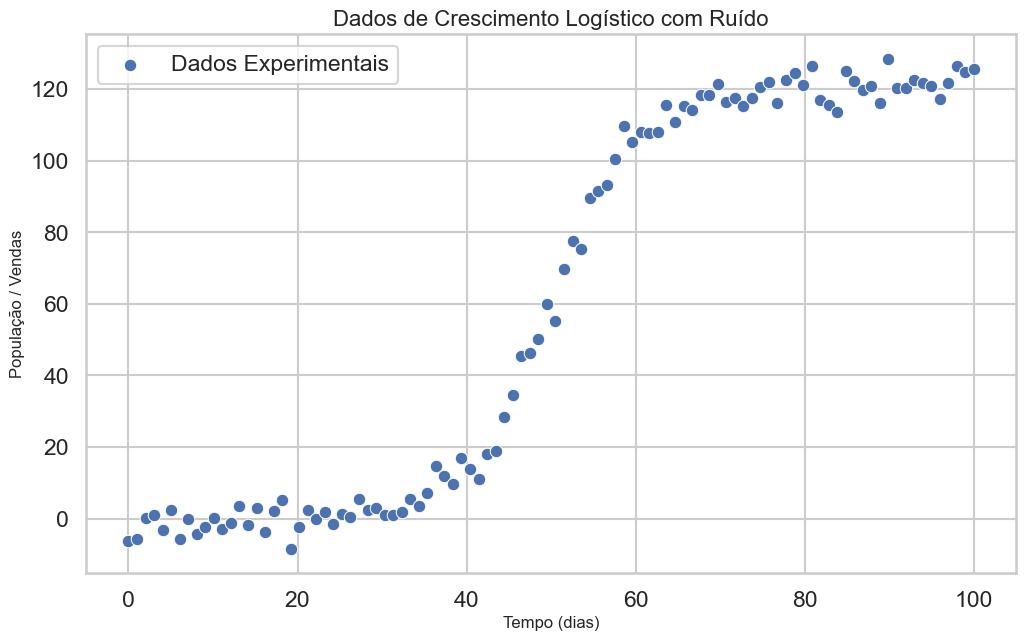

In [111]:
# Importar a biblioteca de otimização do SciPy
from scipy.optimize import curve_fit

# 1. Definir a função do nosso modelo teórico
def modelo_logistico(x, L, k, x0):
    """
    Função logística com parâmetros:
    L: Valor máximo
    k: Taxa de crescimento
    x0: Ponto médio
    """
    return L / (1 + np.exp(-k * (x - x0)))

# 2. Definir os parâmetros "reais" para gerar nossos dados
L_real = 120.0  # Limite máximo de 120 unidades
k_real = 0.2    # Taxa de crescimento
x0_real = 50.0  # O crescimento atinge o pico no tempo x=50

# Gerar o eixo X (ex: 100 dias de observação)
x_data = np.linspace(0, 100, 100)

# Calcular os valores de Y usando o modelo e os parâmetros reais
y_real = modelo_logistico(x_data, L_real, k_real, x0_real)

# Adicionar ruído para simular dados experimentais
ruido = np.random.normal(0, 3.5, size=x_data.size)
y_data = y_real + ruido

# 3. Visualizar nossos dados "experimentais"
plt.figure(figsize=(12, 7))
sns.scatterplot(x=x_data, y=y_data, label='Dados Experimentais')
plt.title('Dados de Crescimento Logístico com Ruído', fontsize=16)
plt.xlabel('Tempo (dias)', fontsize=12)
plt.ylabel('População / Vendas', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### 6.2. Ajuste com `curve_fit` e a Importância das Estimativas Iniciais (`p0`)

O algoritmo por trás do `curve_fit` é um otimizador que precisa de um ponto de partida para começar sua busca pelos melhores parâmetros. Para funções simples, ele geralmente se vira bem sozinho. Mas para modelos com múltiplos parâmetros, como o nosso, um "chute" inicial ruim pode fazer com que o algoritmo não encontre a solução correta (não "convirja").

Felizmente, podemos guiar o otimizador fornecendo estimativas iniciais (`p0`), que podemos extrair simplesmente olhando para o gráfico:
* **Estimativa para `L`**: O valor máximo que os dados atingem. Olhando o gráfico, parece ser em torno de 120.
* **Estimativa para `x0`**: O valor de `x` onde a curva parece estar na metade da sua altura máxima (metade de 120, ou 60). Olhando o gráfico, isso acontece perto de `x=50`.
* **Estimativa para `k`**: Esta é a mais difícil de estimar visualmente, mas ela representa a inclinação. Um valor pequeno e positivo como `0.1` ou `0.2` é um bom chute inicial.

Vamos fornecer essas dicas ao `curve_fit` para garantir um bom resultado.

--- Resultados do Ajuste Não-Linear ---
Parâmetro L (Limite Máximo): 120.99 ± 0.62 (Real: 120.0)
Parâmetro k (Taxa de Crescimento): 0.201 ± 0.006 (Real: 0.2)
Parâmetro x0 (Ponto Médio): 50.13 ± 0.18 (Real: 50.0)

Os valores estimados são muito próximos dos valores reais!


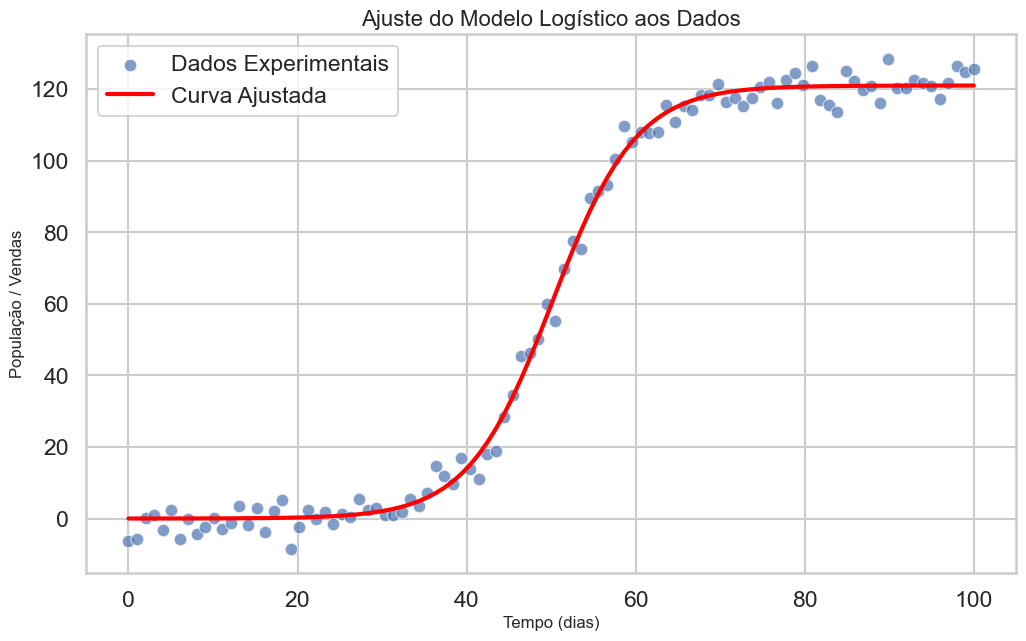

In [112]:
# 1. Definir nossas estimativas iniciais (p0)
#          [L,   k,   x0]
p0 = [120.0, 0.2, 50.0]

# 2. Usar curve_fit com as estimativas iniciais
# popt: contém os parâmetros ótimos encontrados
# pcov: contém a matriz de covariância, que usaremos para estimar o erro
popt, pcov = curve_fit(modelo_logistico, x_data, y_data, p0=p0)

# 3. Extrair os parâmetros e seus erros
L_est, k_est, x0_est = popt
erros = np.sqrt(np.diag(pcov))
L_err, k_err, x0_err = erros

# 4. Apresentar os resultados de forma clara
print("--- Resultados do Ajuste Não-Linear ---")
print(f"Parâmetro L (Limite Máximo): {L_est:.2f} ± {L_err:.2f} (Real: {L_real})")
print(f"Parâmetro k (Taxa de Crescimento): {k_est:.3f} ± {k_err:.3f} (Real: {k_real})")
print(f"Parâmetro x0 (Ponto Médio): {x0_est:.2f} ± {x0_err:.2f} (Real: {x0_real})")
print("\nOs valores estimados são muito próximos dos valores reais!")

# 5. Visualizar o ajuste final
plt.figure(figsize=(12, 7))
sns.scatterplot(x=x_data, y=y_data, label='Dados Experimentais', alpha=0.7)
plt.plot(x_data, modelo_logistico(x_data, *popt), color='red', linewidth=3, label='Curva Ajustada')
plt.title('Ajuste do Modelo Logístico aos Dados', fontsize=16)
plt.xlabel('Tempo (dias)', fontsize=12)
plt.ylabel('População / Vendas', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()